In [535]:
import math
import numpy as np
from numpy import arange
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle

<h1> Import relevant model below then delete me <h1>

In [536]:
from sklearn.linear_model import LinearRegression

<h1> Update model name and display name below then delete me <h1>

In [537]:
model_name = "tuning_template_test_model"
display_name = "Test Model"

In [538]:
y_test = pd.read_csv('y_test_tuning_tests.csv')
file = open("Selection Methods","rb")
sel_methods = np.load(file)

<h1> Update model in pipeline on line 12 then delete me <h1>

In [539]:
def get_best_model(method, args, _cv, is_sample):
    sample_string = ''
    if (is_sample):
        sample_string = '_sample'
    y_train = pd.read_csv('y_train_tuning_tests'+ sample_string + '.csv')    
    method_string = method
    if (method == ''):
        method_string = "no feature selection"
    print('\n\nRunning cross fold validation for',display_name,'with',method_string,'dataset')
    x_train = pd.read_csv('x_train_tuning_tests' + method + sample_string + '.csv').values
    x_test = pd.read_csv('x_test_tuning_tests' + method + '.csv').values
    pipe = Pipeline([('clf', LinearRegression())])
    grid = GridSearchCV(pipe, args, cv = _cv, verbose = 1, scoring = 'r2', n_jobs=6)
    grid.fit(x_train, y_train.values.ravel())
    print('\nBest score for',display_name,'with',method_string,"dataset:",grid.best_score_)
    best_args = grid.best_estimator_.get_params()
    print('\nBest hyperparameters for',display_name,'with',method_string,'dataset:')
    for arg in best_args:
        print(arg,":",best_args[arg])
    y_test_predict = grid.predict(x_test)
    mse = mean_squared_error(y_test,y_test_predict)
    mae = mean_absolute_error(y_test,y_test_predict)
    r2 = r2_score(y_test,y_test_predict)
    print('\nPrediction scores for',display_name,'using',method_string,':')
    print('Mean Squared error:',mse)
    print('Mean Absolute error:',mae)
    print('R^2:',r2)
    #additional variables returned for testing purposes, method itself not amended
    return grid.best_estimator_,grid.best_score_,mse,mae,r2,sample_string, y_train, method_string, x_train, x_test, grid, best_args

In [540]:
def save_model(model,method):
    with open('CrimeGUI/Models/'+model_name+method,'wb') as file:
        pickle.dump(model,file)

In [541]:
print(sel_methods)

['_f_regression' '_chi2' '_adaboost' '_equal_crime_and_business'
 '_all_business']


<h3>Testing begins here<h3>

In [542]:
#helper test method to return simplified list of variables to be tested
def package_variables_to_be_tested(method, args, _cv, is_sample):
    model, score, mse, mae, r2, samp_str, y_train, meth_str, x_train, x_test, grid, best_args = get_best_model(method, 
                                                                                                               args, 
                                                                                                               _cv, 
                                                                                                               is_sample)
    return [model, score, mse, mae, r2, samp_str, y_train, meth_str, x_train, x_test, grid, best_args]

In [543]:
def test_results(results,expected_results):
    assert results, 'Results are null but should be a fully populated list'
    test_pipeline(results[0],expected_results[0])
    #test scores
    assert results[1] == expected_results[1], "Results [1] (Best Score) not as expected"
    assert results[2] == expected_results[2], "Results [2] (MSE) not as expected"
    assert results[3] == expected_results[3], "Results [3] (MAE) not as expected"
    assert results[4] == expected_results[4], "Results [4] (R2) not as expected"
    print('Score tests passed successfully.')
    assert results[5] == expected_results[5], "Results [4] (Sample text) not as expected"
    test_dataframe(results[6],expected_results[6],'y_train')
    assert results[7] == expected_results[7], "Results [7] (Method text) not as expected"
    test_numpy_array(results[8],expected_results[8],'x_train')
    test_numpy_array(results[9],expected_results[9],'x_test')
    test_grid(results[10],expected_results[10],expected_results[0])
    test_best_args(results[11],expected_results[11])
    print('\nAll tests passed successfully.')

In [544]:
def test_pipeline(pipe,expected_params):
    assert pipe and isinstance(pipe, Pipeline), 'Pipe should be a Pipeline, but it does not.'
    pipe_params = pipe.get_params()
    assert pipe_params['memory'] == expected_params['memory'], 'Pipe parameter: Memory not as expected.'
    param_steps = pipe_params['steps']
    assert param_steps, 'Parameter steps are empty but should not be.'
    steps = param_steps[0]
    assert steps, 'Parameter steps tuple is empty but should not be.'
    expected_steps = expected_params['steps'][0]
    assert steps[0] == expected_steps[0], 'Parameter steps tuple [0] not as expected.'
    assert steps[1] and isinstance(steps[1], expected_steps[1]), 'Parameter steps tuple [1] not as expected.'
    assert pipe_params['verbose'] == expected_params['verbose'], 'Pipe parameter: Verbose not as expected.'
    assert isinstance(pipe_params['clf'], expected_params['clf']),'Pipe parameter: clf not as expected.'
    assert pipe_params['clf__copy_X'] == expected_params['clf__copy_X'], 'Pipe parameter: clf__copy_X not as expected.'
    assert pipe_params['clf__fit_intercept'] == expected_params['clf__fit_intercept'], 'Pipe parameter: clf__fit_intercept not as expected.'
    assert pipe_params['clf__n_jobs'] == expected_params['clf__n_jobs'], 'Pipe parameter: clf__n_jobs not as expected.'
    assert pipe_params['clf__normalize'] == expected_params['clf__normalize'], 'Pipe parameter: clf__normalize not as expected.'
    print('Pipeline tests passed successfully.')

In [545]:
def test_dataframe(results,expected_results,df_name):
    assert not results.empty, 'Results are empty but should not be'
    assert len(results) == expected_results['num_records'], 'Dataframe ' + df_name + ' length not as expected'
    for col in results:
        assert col in expected_results['columns'], 'Dataframe ' + df_name + ' columns not as expected'
    for record_num in range(0,len(results.index)):
        j = 0
        while j <= len(expected_results['columns']) - 1:
            assert results[expected_results['columns'][j]].iloc[record_num] == 1, "Value for " + expected_results['columns'][j] + " is not as expected."
            #assert results[expected_results['columns'][j]].iloc[record_num] >= 0 and results[expected_results['columns'][j]].iloc[record_num] <= 1, "Value for " + expected_columns[j] + " is less than 0"
            j += 1
        assert results['Todays Reports'].iloc[record_num] >= 0 , "Value for Todays Reports is less than 0"
    print('Dataset ' + df_name + ' tests passed successfully.')

In [546]:
def test_numpy_array(results,expected_results,data_name):
    alt_expected = 1
    if expected_results['x_zeros_possible']:
        alt_expected = 0
    for i in range(0,expected_results['num_records']):
        for j in range (0,len(results[i])):
            assert results[i][j] == expected_results['value_vals'] or results[i][j] == alt_expected, "Value for array reference [" + str(i) + "][" + str(j) + "] not as expected for dataset " + data_name + "."
    print('Dataset ' + data_name + ' tests passed successfully.')

In [547]:
def test_grid(grid,expected_grid,expected_pipe):
    assert grid and isinstance(grid, GridSearchCV), 'Grid should be a GridSearchCV, but it does not.'
    grid_params = grid.get_params()
    assert grid_params['cv'] == expected_grid['cv'], 'Grid parameter: cv not as expected.'
    assert math.isnan(grid_params['error_score'])
    assert grid_params['estimator__memory'] == expected_grid['estimator__memory'], 'Grid parameter: estimator__memory not as expected.'
    assert grid_params['estimator__steps'], 'Grid parameter: estimator__steps not as expected.'
    estimator_steps = grid_params['estimator__steps'][0]
    assert estimator_steps, 'Grid parameter: estimator__steps not as expected.'
    assert estimator_steps[0] == expected_grid['estimator__steps'][0][0], 'Grid parameter: estimator__steps[0] not as expected.'
    assert estimator_steps[1] and isinstance(estimator_steps[1], expected_grid['estimator__steps'][0][1]), 'Parameter steps tuple [1] not as expected.'
    assert grid_params['estimator__verbose'] == expected_grid['estimator__verbose'], 'Grid parameter: estimator__verbose not as expected.'
    assert grid_params['estimator__clf'] and isinstance(grid_params['estimator__clf'], expected_grid['estimator__clf']), 'Grid parameter: estimator__clf not as expected.'
    assert grid_params['estimator__clf__copy_X'] == expected_grid['estimator__clf__copy_X'], 'Grid parameter: estimator__clf__copy_X not as expected.'
    assert grid_params['estimator__clf__fit_intercept'] == expected_grid['estimator__clf__fit_intercept'], 'Grid parameter: estimator__clf__fit_intercept not as expected.'
    assert grid_params['estimator__clf__n_jobs'] == expected_grid['estimator__clf__n_jobs'], 'Grid parameter: estimator__clf__n_jobs not as expected.'
    assert grid_params['estimator__clf__normalize'] == expected_grid['estimator__clf__normalize'], 'Grid parameter: estimator__clf__normalize not as expected.'
    assert grid_params['estimator'] and isinstance(grid_params['estimator'], Pipeline), 'Grid parameter: estimator not as expected.'
    test_pipeline(grid_params['estimator'],expected_pipe)
    assert grid_params['iid'] == expected_grid['iid'], 'Grid parameter: iid not as expected.'
    assert grid_params['n_jobs'] == expected_grid['n_jobs'], 'Grid parameter: n_jobs not as expected.'
    assert grid_params['param_grid'] == expected_grid['param_grid'], 'Grid parameter: param_grid not as expected.'
    assert grid_params['pre_dispatch'] == expected_grid['pre_dispatch'], 'Grid parameter: pre_dispatch not as expected.'
    assert grid_params['refit'] == expected_grid['refit'], 'Grid parameter: refit not as expected.'
    assert grid_params['return_train_score'] == expected_grid['return_train_score'], 'Grid parameter: return_train_score not as expected.'
    assert grid_params['scoring'] == expected_grid['scoring'], 'Grid parameter: scoring not as expected.'
    assert grid_params['verbose'] == expected_grid['verbose'], 'Grid parameter: verbose not as expected.'
    print('GridSearchCV tests passed successfully.')

In [548]:
def test_best_args(best_args, expected_best_args):
    assert best_args['memory'] == expected_best_args['memory'], 'Best args parameter: memory not as expected.'
    param_steps = best_args['steps']
    assert param_steps, 'Parameter steps are empty but should not be.'
    steps = param_steps[0]
    assert steps, 'Parameter steps tuple is empty but should not be.'
    expected_steps = expected_best_args['steps'][0]
    assert steps[0] == expected_steps[0], 'Parameter steps tuple [0] not as expected.'
    assert steps[1] and isinstance(steps[1], expected_steps[1]), 'Parameter steps tuple [1] not as expected.'
    assert best_args['verbose'] == expected_best_args['verbose'], 'Best args parameter: verbose not as expected.'
    assert best_args['clf__copy_X'] == expected_best_args['clf__copy_X'], 'Best args parameter: clf__copy_X not as expected.'
    assert best_args['clf__fit_intercept'] == expected_best_args['clf__fit_intercept'], 'Best args parameter: clf__fit_intercept not as expected.'
    assert best_args['clf__n_jobs'] == expected_best_args['clf__n_jobs'], 'Best args parameter: clf__n_jobs not as expected.'
    assert best_args['clf__normalize'] == expected_best_args['clf__normalize'], 'Best args parameter: clf__normalize not as expected.'
    print('Best Args tests passed successfully.')

In [549]:
def get_best_model_test(method, is_sample, num_folds,x_zeros_possible):
    args = {}
    results = package_variables_to_be_tested(method,args,num_folds,is_sample)
       
    expected_score = 1
    expected_mse = 0
    expected_mae = 0
    expected_r2 = 1
    expected_sample_string = ""
    num_records = 614
    if is_sample:
        expected_sample_string = "_sample"
        num_records = 153
    expected_method_string = method

    expected_pipeline_vals = {'memory':None,
                              'steps':[('clf',LinearRegression)], 
                              'verbose': False, 
                              'clf': LinearRegression, 
                              'clf__copy_X': True, 
                              'clf__fit_intercept': True, 
                              'clf__n_jobs':None, 
                              'clf__normalize': False
                             }

    expected_y_train_vals = {'num_records':num_records,
                            'value_vals':1,
                            'columns':['Todays Reports']}

    expected_x_train_vals = {'num_records': num_records,
                            'value_vals':1,
                            'x_zeros_possible':x_zeros_possible}

    expected_x_test_vals = {'num_records': 205,
                            'value_vals':1,
                            'x_zeros_possible':x_zeros_possible}

    expected_grid = {'cv': num_folds, 
                     'estimator__memory': None, 
                     'estimator__steps': [('clf', LinearRegression)], 
                     'estimator__verbose': False, 
                     'estimator__clf': LinearRegression, 
                     'estimator__clf__copy_X': True, 
                     'estimator__clf__fit_intercept': True, 
                     'estimator__clf__n_jobs': None, 
                     'estimator__clf__normalize': False, 
                     'estimator': Pipeline(steps=[('clf', LinearRegression())]), 
                     'iid': 'deprecated', 
                     'n_jobs': 6, 
                     'param_grid': {}, 
                     'pre_dispatch': '2*n_jobs', 
                     'refit': True, 
                     'return_train_score': False, 
                     'scoring': 'r2', 
                     'verbose': 1}

    expected_best_args = {'memory': None, 
                          'steps': [('clf', LinearRegression)], 
                          'verbose': False, 
                          'clf': LinearRegression, 
                          'clf__copy_X': True, 
                          'clf__fit_intercept': True, 
                          'clf__n_jobs': None, 
                          'clf__normalize': False}

    expected_results = [expected_pipeline_vals, expected_score, expected_mse, expected_mae, expected_r2, expected_sample_string,
                        expected_y_train_vals, expected_method_string, expected_x_train_vals, expected_x_test_vals,
                        expected_grid, expected_best_args]
    
    test_results(results,expected_results)
    return results[0],results[1],results[2],results[3],results[4]

<h3> F-regression tests <h3>

In [550]:
get_best_model_test(method = '_f_regression', is_sample = True, num_folds = 5, x_zeros_possible = False)



Running cross fold validation for Test Model with _f_regression dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _f_regression dataset: 1.0

Best hyperparameters for Test Model with _f_regression dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _f_regression :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [551]:
get_best_model_test(method = '_f_regression', is_sample = True, num_folds = 10, x_zeros_possible = False)



Running cross fold validation for Test Model with _f_regression dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _f_regression dataset: 1.0

Best hyperparameters for Test Model with _f_regression dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _f_regression :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [552]:
get_best_model_test(method = '_f_regression', is_sample = False, num_folds = 5, x_zeros_possible = False)



Running cross fold validation for Test Model with _f_regression dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _f_regression dataset: 1.0

Best hyperparameters for Test Model with _f_regression dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _f_regression :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [553]:
get_best_model_test(method = '_f_regression', is_sample = False, num_folds = 10, x_zeros_possible = False)



Running cross fold validation for Test Model with _f_regression dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished



Best score for Test Model with _f_regression dataset: 1.0

Best hyperparameters for Test Model with _f_regression dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _f_regression :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

<h3>Chi-Squared tests<h3>

In [554]:
get_best_model_test(method = '_chi2', is_sample = True, num_folds = 5, x_zeros_possible = True)



Running cross fold validation for Test Model with _chi2 dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _chi2 dataset: 1.0

Best hyperparameters for Test Model with _chi2 dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


clf__normalize : False

Prediction scores for Test Model using _chi2 :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [555]:
get_best_model_test(method = '_chi2', is_sample = True, num_folds = 10, x_zeros_possible = True)



Running cross fold validation for Test Model with _chi2 dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _chi2 dataset: 1.0

Best hyperparameters for Test Model with _chi2 dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _chi2 :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [556]:
get_best_model_test(method = '_chi2', is_sample = False, num_folds = 5, x_zeros_possible = True)



Running cross fold validation for Test Model with _chi2 dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _chi2 dataset: 1.0

Best hyperparameters for Test Model with _chi2 dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _chi2 :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [557]:
get_best_model_test(method = '_chi2', is_sample = False, num_folds = 10, x_zeros_possible = True)



Running cross fold validation for Test Model with _chi2 dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished



Best score for Test Model with _chi2 dataset: 1.0

Best hyperparameters for Test Model with _chi2 dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _chi2 :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

<h3>AdaBoost tests<h3>

In [558]:
get_best_model_test(method = '_adaboost', is_sample = True, num_folds = 5, x_zeros_possible = False)



Running cross fold validation for Test Model with _adaboost dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _adaboost dataset: 1.0

Best hyperparameters for Test Model with _adaboost dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


 : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _adaboost :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [559]:
get_best_model_test(method = '_adaboost', is_sample = True, num_folds = 10, x_zeros_possible = False)



Running cross fold validation for Test Model with _adaboost dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _adaboost dataset: 1.0

Best hyperparameters for Test Model with _adaboost dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _adaboost :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [560]:
get_best_model_test(method = '_adaboost', is_sample = False, num_folds = 5, x_zeros_possible = False)



Running cross fold validation for Test Model with _adaboost dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _adaboost dataset: 1.0

Best hyperparameters for Test Model with _adaboost dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _adaboost :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [561]:
get_best_model_test(method = '_adaboost', is_sample = False,  num_folds = 10, x_zeros_possible = False)



Running cross fold validation for Test Model with _adaboost dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _adaboost dataset: 1.0

Best hyperparameters for Test Model with _adaboost dataset:
memory : None
steps : [('clf', LinearRegression())]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished



verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _adaboost :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

<h3>Equal business and crime tests<h3>

In [562]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = True, num_folds = 5, x_zeros_possible = False)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.




Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [563]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = True, num_folds = 10, x_zeros_possible = False)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished




Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [564]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = False, num_folds = 5, x_zeros_possible = False)



Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished



Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [565]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = False, num_folds = 10, x_zeros_possible = False)



Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished



Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

<h3>Business only tests<h3>

In [566]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = True, num_folds = 5, x_zeros_possible = False)



Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished



Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [567]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = True, num_folds = 10, x_zeros_possible = False)



Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [568]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = False, num_folds = 5, x_zeros_possible = False)



Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

In [569]:
get_best_model_test(method = '_equal_crime_and_business', is_sample = False, num_folds = 10, x_zeros_possible = False)



Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business 

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


:
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


(Pipeline(steps=[('clf', LinearRegression())]), 1.0, 0.0, 0.0, 1.0)

<h3> Save model testing <h3>

In [570]:
#train and test an arbitrary model
model = get_best_model_test(method = '_f_regression', is_sample = True, num_folds = 5, x_zeros_possible = False)[0]



Running cross fold validation for Test Model with _f_regression dataset
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best score for Test Model with _f_regression dataset: 1.0

Best hyperparameters for Test Model with _f_regression dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _f_regression :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    0.0s finished


In [571]:
method_name = '_arbitrary_name'

In [572]:
save_model(model, method_name)

In [573]:
file_path = 'CrimeGUI/Models/' + model_name + method_name

In [574]:
with open(file_path, 'rb') as f:
    model = pickle.load(f)

In [575]:
print(model)

Pipeline(steps=[('clf', LinearRegression())])


In [576]:
expected_pipeline_vals = {'memory':None,
                              'steps':[('clf',LinearRegression)], 
                              'verbose': False, 
                              'clf': LinearRegression, 
                              'clf__copy_X': True, 
                              'clf__fit_intercept': True, 
                              'clf__n_jobs':None, 
                              'clf__normalize': False
                             }

In [577]:
test_pipeline(model, expected_pipeline_vals)

Pipeline tests passed successfully.


In [578]:
#Model saving with correct hyperparameters confirmed

<h3>Score Visualisation tests<h3>

In [579]:
# train five arbitrary models
f_reg_model, f_reg_train_score, f_reg_mse, f_reg_mae, f_reg_r2 = get_best_model_test(method = '_f_regression', 
                                                                                     is_sample = False, 
                                                                                     num_folds = 10, 
                                                                                     x_zeros_possible = False)
chi2_model, chi2_train_score, chi2_mse, chi2_mae, chi2_r2 = get_best_model_test(method = '_chi2', 
                                                                                     is_sample = False, 
                                                                                     num_folds = 10, 
                                                                                     x_zeros_possible = True)
ada_model, ada_train_score, ada_mse, ada_mae, ada_r2 = get_best_model_test(method = '_adaboost', 
                                                                                is_sample = False, 
                                                                                num_folds = 10, 
                                                                                x_zeros_possible = False)
equal_model, equal_train_score, equal_mse, equal_mae, equal_r2 = get_best_model_test(method = '_equal_crime_and_business', 
                                                                                     is_sample = False, 
                                                                                     num_folds = 10, 
                                                                                     x_zeros_possible = False)
bus_model, bus_train_score, bus_mse, bus_mae, bus_r2 = get_best_model_test(method = '_equal_crime_and_business', 
                                                                           is_sample = False, 
                                                                           num_folds = 10, 
                                                                           x_zeros_possible = False)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.




Running cross fold validation for Test Model with _f_regression dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _f_regression dataset: 1.0

Best hyperparameters for Test Model with _f_regression dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _f_regression :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


Running cross fold validation for Test Model with _chi2 dataset
Fitting 10 folds for each of 1 candidat

[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


Dataset y_train tests passed successfully.
Dataset x_train tests passed successfully.
Dataset x_test tests passed successfully.
Pipeline tests passed successfully.
GridSearchCV tests passed successfully.
Best Args tests passed successfully.

All tests passed successfully.


Running cross fold validation for Test Model with _equal_crime_and_business dataset
Fitting 10 folds for each of 1 candidates, totalling 10 fits

Best score for Test Model with _equal_crime_and_business dataset: 1.0

Best hyperparameters for Test Model with _equal_crime_and_business dataset:
memory : None
steps : [('clf', LinearRegression())]
verbose : False
clf : LinearRegression()
clf__copy_X : True
clf__fit_intercept : True
clf__n_jobs : None
clf__normalize : False

Prediction scores for Test Model using _equal_crime_and_business :
Mean Squared error: 0.0
Mean Absolute error: 0.0
R^2: 1.0
Pipeline tests passed successfully.
Score tests passed successfully.
Dataset y_train tests passed successfully.
Dataset x_trai

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    0.0s finished


In [580]:
def test_bar_chart(bar, expected_height, x_label, y_label, expected_y, x_ticks, expected_title, title):
    rectangles = bar.get_children()
    for rectangle in rectangles:
        assert rectangle.get_height() == expected_height,"Height of a rectangle not as expected."
    assert x_label.get_text() == "Dataset", "x label not as expected."
    assert y_label.get_text() == expected_y, "y label not as expected."
    sub_headings = x_ticks[1]
    assert sub_headings, "Sub-headings not as expected"
    for i in range(0,len(sub_headings)):
        assert sub_headings[i].get_text() == datasets[i], "Sub-headings not as expected"
    print("All bar chart tests completed successfully.")

In [581]:
training_scores = [f_reg_train_score, chi2_train_score, ada_train_score, equal_train_score, bus_train_score]
mse_scores = [f_reg_mse, chi2_mse, ada_mse, equal_mse, bus_mse]
mae_scores = [f_reg_mae, chi2_mae, ada_mae, equal_mae, bus_mae]
r2_scores = [f_reg_r2, chi2_r2, ada_r2, equal_r2, bus_r2]
datasets = ["F-Regression","Chi-Squared","AdaBoost","Equal Business\nand Crime","All Business"]
y_select = np.arange(len(datasets))

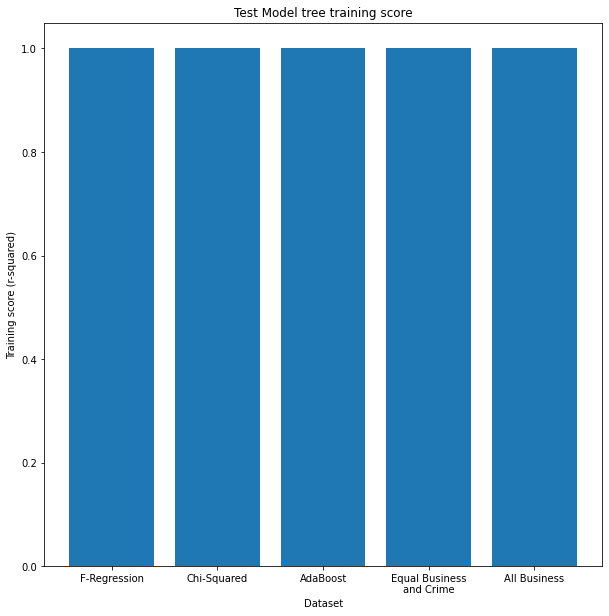

In [582]:
plt.figure(figsize = (10,10))
training_x_ticks = plt.xticks(y_select,datasets)
training_title = plt.title(display_name + " tree training score")
training_x_label = plt.xlabel("Dataset")
training_y_label = plt.ylabel("Training score (r-squared)")
training_bar = plt.bar(y_select, training_scores)

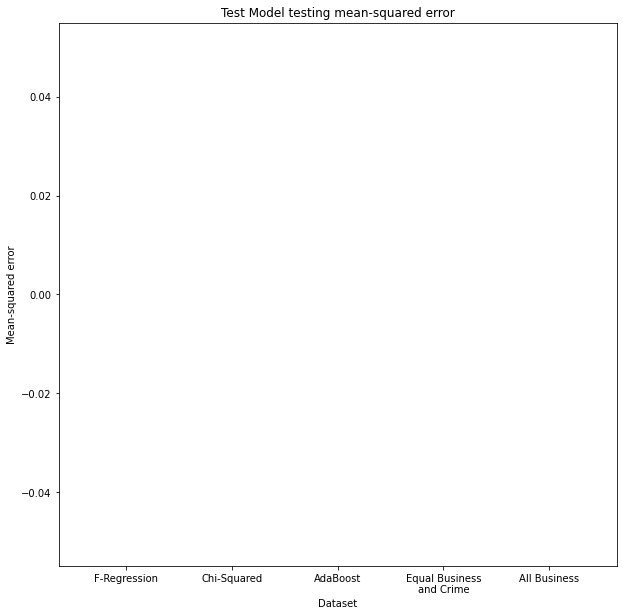

In [583]:
plt.figure(figsize = (10,10))
mse_x_ticks = plt.xticks(y_select,datasets)
mse_title = plt.title(display_name + " testing mean-squared error")
mse_x_label = plt.xlabel("Dataset")
mse_y_label = plt.ylabel("Mean-squared error")
mse_bar = plt.bar(y_select, mse_scores)

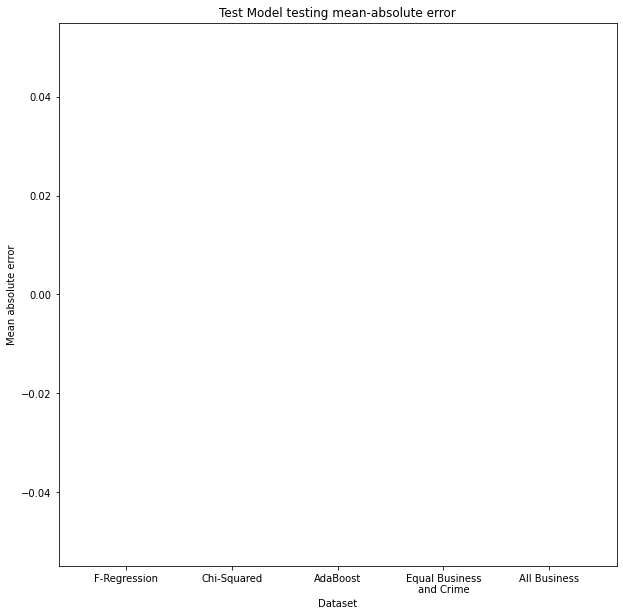

In [584]:
plt.figure(figsize = (10,10))
mae_x_ticks = plt.xticks(y_select,datasets)
mae_title = plt.title(display_name + " testing mean-absolute error")
mae_x_label = plt.xlabel("Dataset")
mae_y_label = plt.ylabel("Mean absolute error")
mae_bar = plt.bar(y_select, mae_scores)

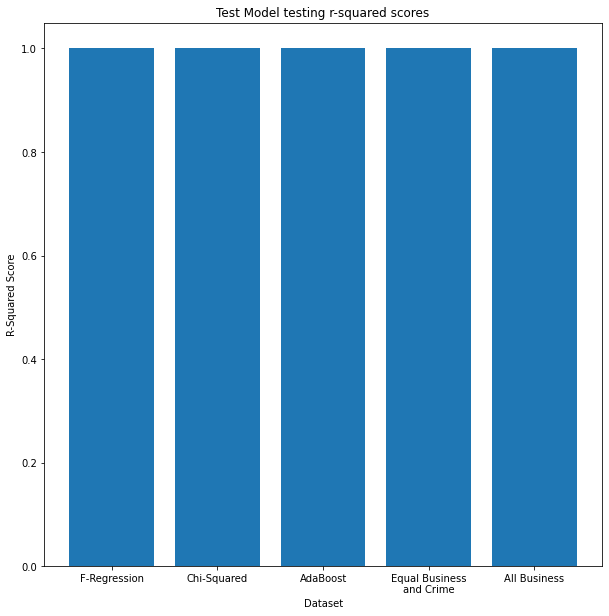

In [585]:
plt.figure(figsize = (10,10))
testing_x_ticks = plt.xticks(y_select,datasets)
testing_title = plt.title(display_name + " testing r-squared scores")
testing_x_label = plt.xlabel("Dataset")
testing_y_label = plt.ylabel("R-Squared Score")
testing_bar = plt.bar(y_select, r2_scores)

In [586]:
expected_height = 1
expected_y = "Training score (r-squared)"
expected_title = "Test model testing r-squared scores"
test_bar_chart(training_bar, 
               expected_height, 
               training_x_label, 
               training_y_label, 
               expected_y, 
               training_x_ticks, 
               training_title, 
               expected_title)

All bar chart tests completed successfully.


In [587]:
expected_height = 0
expected_y = "Mean-squared error"
expected_title = "Test model testing r-squared scores"
test_bar_chart(mse_bar, 
               expected_height, 
               mse_x_label, 
               mse_y_label, 
               expected_y, 
               mse_x_ticks,
               mse_title,
               expected_title)

All bar chart tests completed successfully.


In [588]:
expected_height = 0
expected_y = "Mean absolute error"
expected_title = "Test model testing r-squared scores"
test_bar_chart(mae_bar, 
               expected_height, 
               mae_x_label, 
               mae_y_label, 
               expected_y, 
               mae_x_ticks, 
               mae_title,
               expected_title)

All bar chart tests completed successfully.


In [589]:
expected_height = 1
expected_y = "R-Squared Score"
expected_title = "Test model testing r-squared scores"
test_bar_chart(testing_bar, 
               expected_height, 
               testing_x_label, 
               testing_y_label, 
               expected_y, 
               testing_x_ticks, 
               testing_title,
               expected_title)

All bar chart tests completed successfully.
